## Kết nối colab vs drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import thư viện

In [3]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import glob
import albumentations as A
from tqdm import tqdm
import os

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Đọc dữ liệu

In [5]:
data_path = '/content/gdrive/MyDrive/165.Image_classification_using_transformer/data'

### Tạo ra Dataframe chứa đường dẫn + nhãn

In [6]:
No_Data_Path = f"{data_path}/no"
Yes_Data_Path = f"{data_path}/yes"    

In [7]:
No_JPG_Path = list(glob.glob(f"{No_Data_Path}/*.jpg"))
Yes_JPG_Path = list(glob.glob(f"{Yes_Data_Path}/*.jpg"))

Yes_No_List = []

for No_JPG in No_JPG_Path:
    Yes_No_List.append(No_JPG)
    
for Yes_JPG in Yes_JPG_Path:
    Yes_No_List.append(Yes_JPG)

In [8]:
JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Yes_No_List))

In [9]:
print(JPG_Labels[0:10])
print("NO COUNTING: ", JPG_Labels.count("no"))
print("YES COUNTING: ", JPG_Labels.count("yes"))

['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']
NO COUNTING:  1500
YES COUNTING:  1500


In [10]:
JPG_Path_Series = pd.Series(Yes_No_List,name="Image").astype(str)
JPG_Category_Series = pd.Series(JPG_Labels,name="Class")

In [11]:
Main_Train_Data = pd.concat([JPG_Path_Series,JPG_Category_Series],axis=1)
Main_Train_Data.head()

,Image,Class
0,/content/gdrive/MyDrive/165.Image_classificati...,no
1,/content/gdrive/MyDrive/165.Image_classificati...,no
2,/content/gdrive/MyDrive/165.Image_classificati...,no
3,/content/gdrive/MyDrive/165.Image_classificati...,no
4,/content/gdrive/MyDrive/165.Image_classificati...,no


### Chia dataframe trên thành 2 tập

In [12]:
Main_Train_Data['Kfold']=-1
train_df=Main_Train_Data.sample(frac=1).reset_index(drop=True)
y=train_df['Class']
kf=StratifiedKFold(n_splits=10)
for fold,(t_,v_) in enumerate(kf.split(X=train_df,y=y)):
    train_df.loc[v_,'Kfold']=fold
train_data_df=train_df[train_df['Kfold']!=4]
valid_data_df=train_df[train_df['Kfold']==4]

# Khởi tạo config

In [13]:
num_classes = 2
IMAGE_SIZE = 224
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
image_size = IMAGE_SIZE  
patch_size = 6 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

IMAGE_SHAPE = (IMAGE_SIZE,IMAGE_SIZE,3)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Đọc dữ liệu ảnh

In [14]:
train_transforms = A.Compose([
            A.Rotate(limit=40),
            A.Cutout(num_holes=4,max_h_size=8,max_w_size=8),
            A.ShiftScaleRotate(),
            A.RandomRotate90(),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.RandomGridShuffle()
        ])

def augumentation_preproc(image):
    data = {"image":image}
    aug_data = train_transforms(**data)
    aug_img = aug_data["image"]
    return aug_img

     

train_datagen = ImageDataGenerator(rescale=1./255.,  preprocessing_function=augumentation_preproc)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_data_df,
    directory="",
    x_col="Image",
    y_col="Class",
    subset="training",
    batch_size=batch_size ,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
  
)

val_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator=val_datagen.flow_from_dataframe(
    dataframe=valid_data_df,
    directory="",
    x_col="Image",
    y_col="Class",
    subset="training",
    batch_size=batch_size ,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Found 2700 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [15]:
# In ra tên lớp và encode tương ứng
classes = train_generator.class_indices
classes = dict((v,k) for k,v in classes.items())
classes

{0: 'no', 1: 'yes'}

### Trực quan hóa dữ liệu

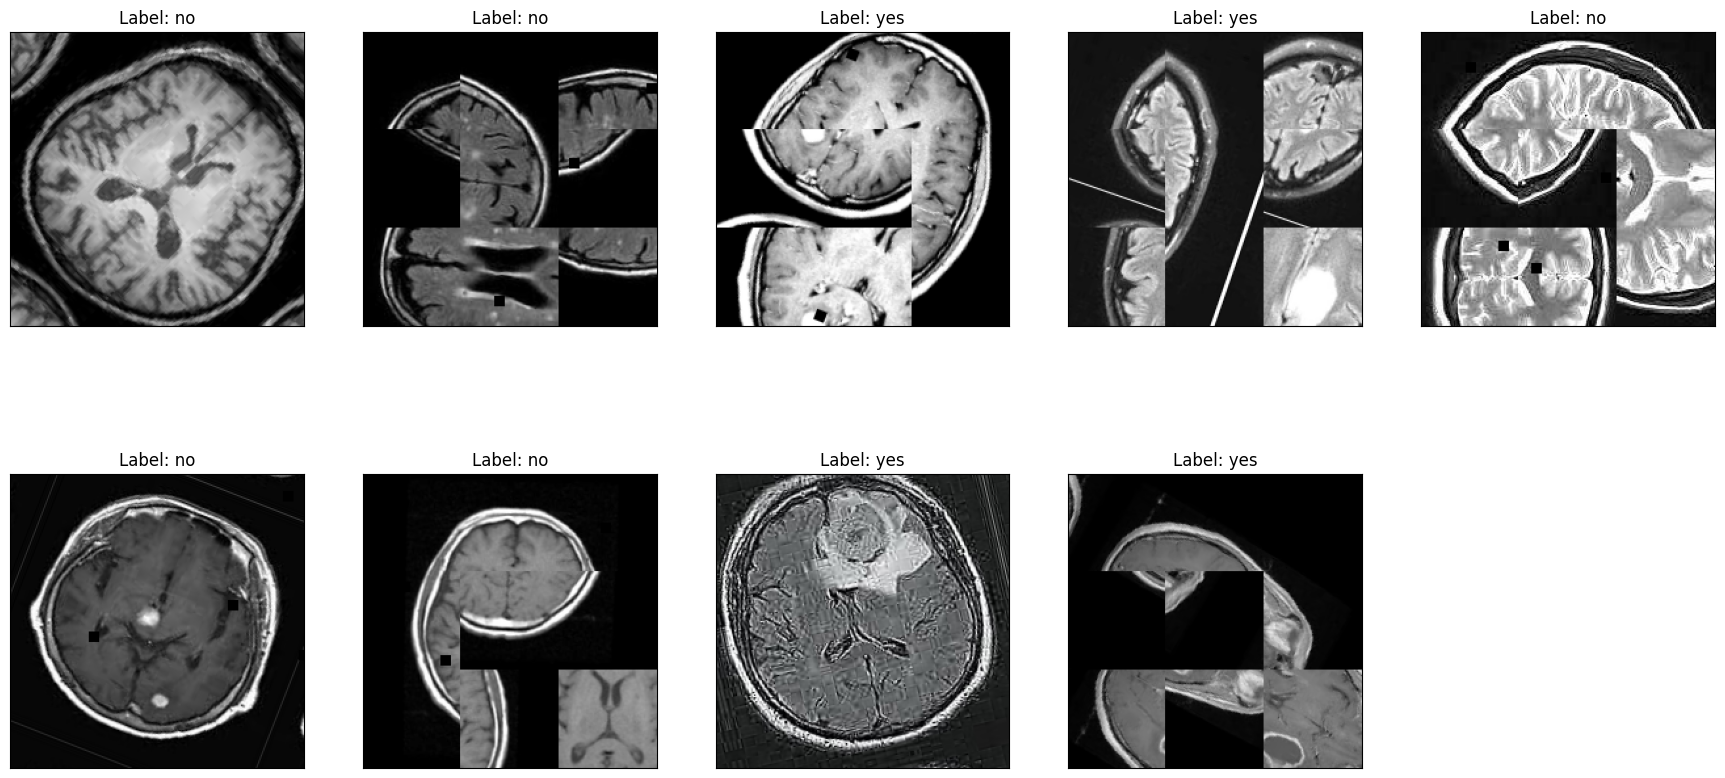

In [16]:
def view_images(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset

    fig = plt.figure(figsize=(22, 22))
    for i in range(9):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {classes[np.argmax(label[i])]}")
view_images(train_generator)

In [17]:
# Trọng số của từng lớp
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
class_weights

{1: 1.0, 0: 1.0}

## Sử dụng data augmentation

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)

# Xây Vision transformer model (ViT)

In [19]:
!pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=75863f08cef1fe38eee644626e01f4ee04367c4ba290fc9f502ffadbc842df9f
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [20]:
# def mlp(x, hidden_units, dropout_rate):
#     for units in hidden_units:
#         x = layers.Dense(units, activation=tf.nn.gelu)(x)
#         x = layers.Dropout(dropout_rate)(x)
#     return x

# class Patches(layers.Layer):
#     def __init__(self, patch_size):
#         super(Patches, self).__init__()
#         self.patch_size = patch_size

#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding="VALID",
#         )
#         patch_dims = patches.shape[-1]
#         patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         return patches
    
# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, projection_dim):
#         super(PatchEncoder, self).__init__()
#         self.num_patches = num_patches
#         self.projection = layers.Dense(units=projection_dim)
#         self.position_embedding = layers.Embedding(
#             input_dim=num_patches, output_dim=projection_dim
#         )

#     def call(self, patch):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patch) + self.position_embedding(positions)
#         return encoded

In [21]:
from vit_keras import vit, utils

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)


    pre_trained_model = vit.vit_l32(
        image_size=IMAGE_SIZE,
        activation='sigmoid',
        pretrained=True,
        include_top=True,
        pretrained_top=True,
        classes=num_classes
    )
    pre_trained_model.trainable = False
    features = pre_trained_model(augmented)
    features = layers.Dense(512, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(256, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(128, activation=layers.PReLU())(features)
    features = layers.Dropout(0.2)(features)

    outputs = layers.Dense(num_classes, activation="softmax")(features)
    model = keras.Model(inputs=inputs,outputs=outputs)
    return model

/usr/local/lib/python3.10/dist-packages/vit_keras/vit.py:139: UserWarning: Can only use pretrained_top with imagenet21k+imagenet2012 if classes = 1000. Setting manually.
  warnings.warn(


1226658854/1226658854 [==============================] - 7s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/30
11/11 [==============================] - 367s 30s/step - loss: 4.3206 - accuracy: 0.5056 - top-2-accuracy: 1.0000 - val_loss: 0.6936 - val_accuracy: 0.5000 - val_top-2-accuracy: 1.0000
Epoch 2/30
11/11 [==============================] - 25s 2s/step - loss: 0.7232 - accuracy: 0.4952 - top-2-accuracy: 1.0000 - val_loss: 0.6990 - val_accuracy: 0.5000 - val_top-2-accuracy: 1.0000
Epoch 3/30
11/11 [==============================] - 25s 2s/step - loss: 0.7085 - accuracy: 0.5000 - top-2-accuracy: 1.0000 - val_loss: 0.6850 - val_accuracy: 0.5000 - val_top-2-accuracy: 1.0000
Epoch 4/30
11/11 [==============================] - 25s 2s/step - loss: 0.7068 - accuracy: 0.5085 - top-2-accuracy: 1.0000 - val_loss: 0.6859 - val_accuracy: 0.5000 - val_top-2-accuracy: 1.0000
Epoch 5/30
11/11 [==============================] - 30s 3s/step - loss: 0.6931 - accuracy: 0.5233 - top-2-accuracy: 1.0000 - val_loss: 0.6781 - val_accuracy: 0.8333 - val_top-2-accuracy: 1.0000
Epoch 6/30
11/11 [==========

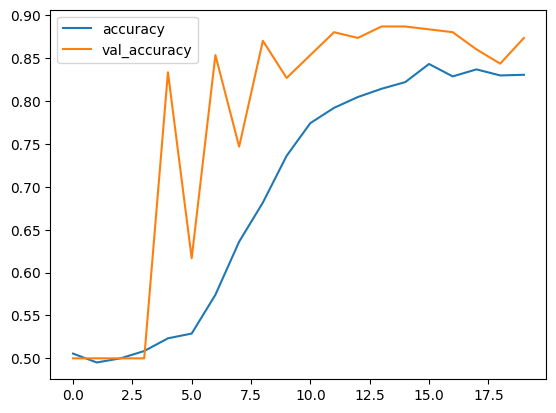

In [22]:
def run_experiment(model):
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(2, name="top-2-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
    history = model.fit(
        train_generator,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights,
        validation_data=valid_generator,
        callbacks=[checkpoint_callback,early_stopping],
    )
    pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()
    model.save("./vit_best_model.h5")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

In [23]:
# in ra độ chính xác của mô hình
print('Test accuracy ViT:', max(history.history["val_accuracy"]))

Test accuracy ViT: 0.8866666555404663


# Xây MobileNetV2 model

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import Sequential

def MobileNetV2_model(learning_rate, input_shape,class_number):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:
        layer.trainable = False
   
    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax'))

    return model

In [25]:
model_mobileNetv2 = MobileNetV2_model(learning_rate,IMAGE_SHAPE,2)
model_mobileNetv2.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/30
11/11 [==============================] - 34s 2s/step - loss: 1.0599 - accuracy: 0.6248 - val_loss: 0.4498 - val_accuracy: 0.8300
Epoch 2/30
11/11 [==============================] - 23s 2s/step - loss: 0.5877 - accuracy: 0.7130 - val_loss: 0.4939 - val_accuracy: 0.7867
Epoch 3/30
11/11 [==============================] - 22s 2s/step - loss: 0.4622 - accuracy: 0.7819 - val_loss: 0.3591 - val_accuracy: 0.8833
Epoch 4/30
11/11 [==============================] - 22s 2s/step - loss: 0.3964 - accuracy: 0.8267 - val_loss: 0.2819 - val_accuracy: 0.9067
Epoch 5/30
11/11 [==============================] - 22s 2s/step - loss: 0.3573 - accuracy: 0.8452 - val_loss: 0.2335 - val_accuracy: 0.8967
Epoch 6/30
11/11 [==============================] - 22s 2s/step - loss: 0.3560 - accuracy: 0.8548 - val_loss: 0.2137 - val_accuracy: 0.8900
Epoch 7/30
11/11 [==============================] - 22s 2s/step - loss: 0.3185 - accuracy: 0.8704 - val_loss: 0.1780 - val_accuracy: 0.9333
Epoch 8/30
11/11 [==

<Axes: >

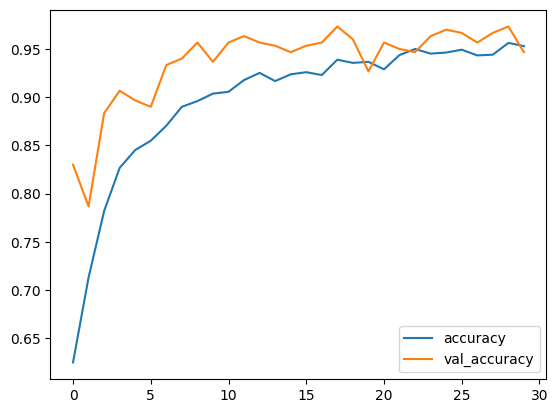

In [26]:
history_2 = model_mobileNetv2.fit(train_generator,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=valid_generator)
pd.DataFrame(history_2.history)[["accuracy","val_accuracy"]].plot()

In [27]:
# in ra độ chính xác của mô hình
print('Test accuracy MobileNetV2:', max(history_2.history["val_accuracy"]))

Test accuracy MobileNetV2: 0.9733333587646484
